# Take Home Test AI Engineer Ada Mata

Dikarenakan ketentuannya adalah menggunakan dataset trashnet yang disediakan oleh huggingface, maka kita install huggingface datasets terlebih dahulu

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Dibawah ini, kita akan mengimport library / package yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from collections import Counter
import pandas as pd

Load dataset trashnet

In [ ]:
from datasets import load_dataset

ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

Kita lihat isi dari raw dataset yang telah diload

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


Disini kita akan cek keseluruhan label yang terdapat pada dataset

In [ ]:
label_name = ds['train'].features['label'].names

print("Label Classes:", label_name)

Label Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Exploratory Image Analysis

Dibawah ini kita akan membuat sebuah function yang akan menampilkan sampel foto sebanyak 6 dari dataset beserta dengan label dari foto tersebut

In [ ]:
dataset = ds['train']

def display_random_images(dataset, labels, num_images=6):

   num_rows = 2
   num_cols = np.ceil(num_images / num_rows).astype(int)

   plt.figure(figsize=(num_cols * 3, num_rows * 3))
   indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)

   for i, idx in enumerate(indices, 1):
       idx = int(idx)
       image = dataset[idx]['image']
       label = dataset[idx]['label']
       label_name = labels[label]

       plt.subplot(num_rows, num_cols, i)
       plt.imshow(image)
       plt.title(f"{label_name} ({label})")
       plt.axis('off')

   plt.tight_layout()
   plt.show()

Kita gunakan function yang telah dibuat

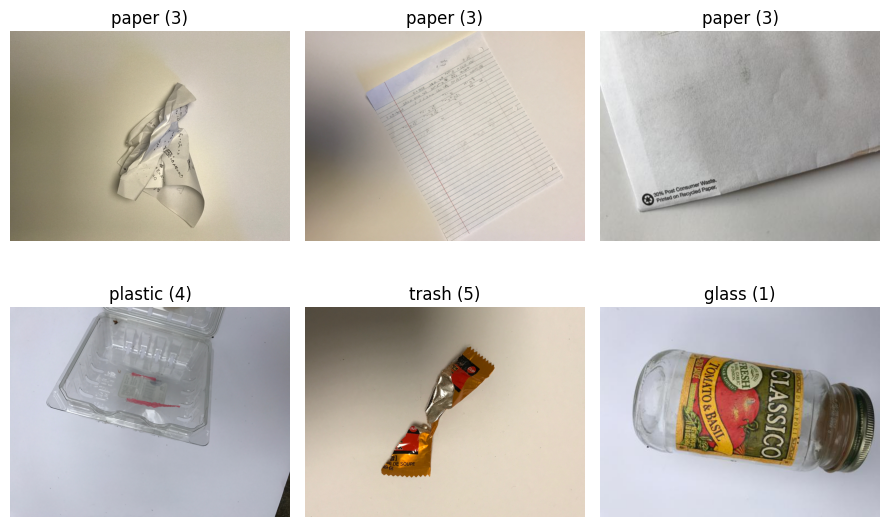

In [ ]:
display_random_images(dataset, label_name)

Membuat sebuah dictionary yang berisi key sebuah index dan value nama label yang ada

In [ ]:
id_to_label = dict()

for i, label in enumerate(label_name):
  id_to_label[i] = label

In [ ]:
id_to_label

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

Membuat sebuah function yang akan menampilkan distribusi image per label yang ada pada dataset

In [ ]:
def visualize_dataset_distribution(dataset, label_name):
  all_labels = []
  for split in dataset.keys():
      all_labels.extend(dataset[split]['label'])

  label_counts = Counter(all_labels)

  label_counts = {label_name[key]: value for key, value in label_counts.items()}

  df = pd.DataFrame({
      'Class': list(label_counts.keys()),
      'Count': list(label_counts.values())
  })

  plt.figure(figsize=(12, 6))
  sns.barplot(data=df, x='Class', y='Count')

  plt.title('Distribution of Classes in Trashnet Dataset (All Splits)', pad=20)
  plt.xlabel('Class Name')
  plt.ylabel('Number of Images')

  for i, v in enumerate(df['Count']):
      plt.text(i, v + 5, str(v), ha='center')

  plt.xticks(rotation=45)

  plt.tight_layout()

Dapat kita lihat dari hasil dibawah, ternyata distribusi dataset tidak merata, dataset ini didominasi oleh label paper sebanyak 1188 image dan label paling sedikit adalah trash sebanyak 274 image, ini menunjukkan bahwa terdapat ketidakseimbangan pada dataset ini

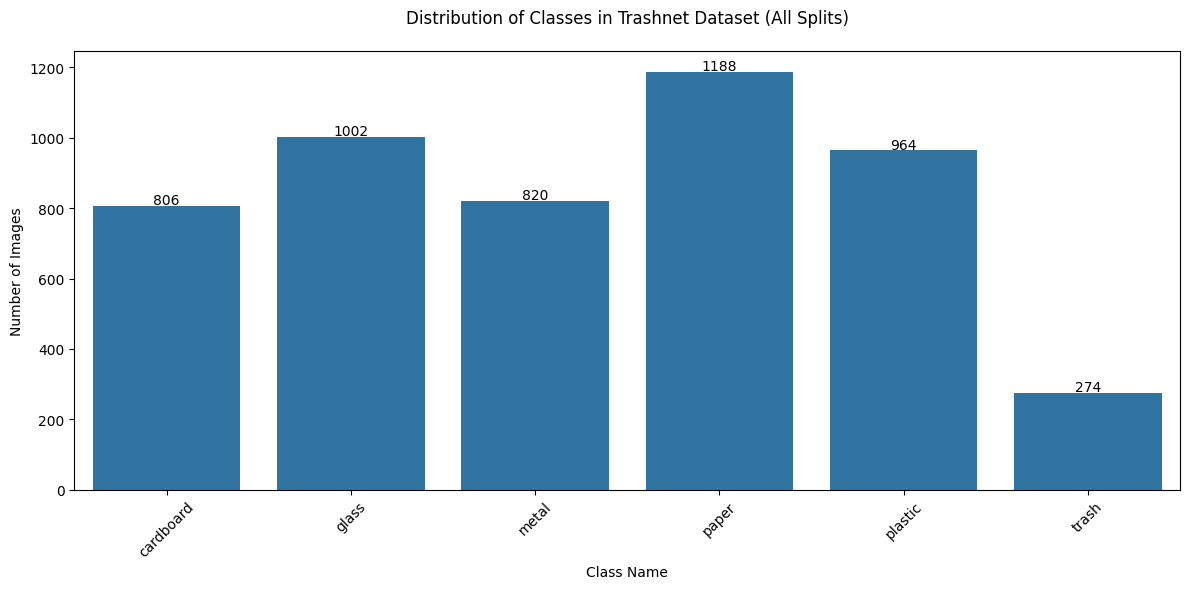

In [ ]:
visualize_dataset_distribution(ds, id_to_label)

Membuat sebuah function yang akan menampilkan pixel sampel image (10), dan dapat kita lihat dari hasil dibawah, ternyata dari 10 sampel yang digenerate pixelnya, terdapat 2 jenis pixel yaitu (4032x3024) dan (3024x4032)

In [ ]:
num_samples = 10
samples = dataset.select(range(num_samples))

def calculate_total_pixels(image):
    image_array = np.array(image)
    height, width = image_array.shape[:2]
    return height, width

results = [calculate_total_pixels(sample['image']) for sample in samples]

for i, (height, width) in enumerate(results):
    print(f"Image {i+1}: {height}x{width}")

Image 1: 4032x3024
Image 2: 4032x3024
Image 3: 3024x4032
Image 4: 4032x3024
Image 5: 4032x3024
Image 6: 3024x4032
Image 7: 4032x3024
Image 8: 3024x4032
Image 9: 3024x4032
Image 10: 3024x4032


## Data Pre-Processing

Dikarenakan dataset tidak memiliki split secara otomatis saat diload, maka saatnya kita split dataset secara manual dengan method yang telah disediakan, kita akan membagi dataset dengan rasio 80:10:10 untuk training, validation dan testing

In [ ]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_dataset['train']
test_val_split = split_dataset['test'].train_test_split(test_size=0.5, seed=42)
test_dataset = test_val_split['test']
val_dataset = test_val_split['train']

Kita akan melihat distribusi dari dataset yang telah displit

In [ ]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 4043
Validation size: 505
Test size: 506


Lalu kita akan melakukan pre-processing image, pertama tama adalah meresize ukuran image menjadi 150x150 karena keterbatasan memori, lalu setelahnya kita akan menormalisasi image agar pixel memiliki rentang 0-1, normalisasi ini membuat model lebih stabil dan mempercepat pelatihan.

In [ ]:
image_size = (150, 150)

def preprocess(dataset):
    dataset['image'] = tf.image.resize(dataset['image'], (image_size))
    dataset['image'] = tf.cast(dataset['image'], tf.float32) / 255.0
    return dataset

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Map:   0%|          | 0/4043 [00:00<?, ? examples/s]

Map:   0%|          | 0/505 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

Karena kita akan menggunakan tensorflow sebagai framework untuk membangun model deep learning, maka kita ubah terlebih dahulu dataset dari huggingface menjadi tensorflow dataset

In [ ]:
train_dataset = train_dataset.to_tf_dataset(
    columns='image',
    label_cols='label',
    batch_size=32,
    shuffle=True
)

val_dataset = val_dataset.to_tf_dataset(
    columns='image',
    label_cols='label',
    batch_size=32,
    shuffle=True
)

test_dataset = test_dataset.to_tf_dataset(
    columns='image',
    label_cols='label',
    batch_size=32,
    shuffle=False
)

## Model Training

Membuat fungsi untuk arsitektur model beserta menentukan compilernya seperti optimizer, loss function dan metrics untuk melacak selama pelatihan

In [ ]:
def create_model(label):

  input = tf.keras.Input(shape=(150, 150, 3))
  x = layers.Conv2D(64, (3, 3), activation='relu')(input)
  x = layers.MaxPooling2D(2, 2)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(2, 2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(2, 2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu')(x)
  x = layers.MaxPooling2D(2, 2)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.15)(x)
  output = layers.Dense(len(label), activation='softmax')(x)

  model = Model(inputs=input, outputs=output)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model

In [ ]:
model = create_model(label_name)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,014,278 (7.68 MB)

 Trainable params: 2,014,278 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

Membuat callback untuk otomatis menyimpan model selama pelatihan dengan memantau validation loss dan hanya model terbaik yang akan disimpan, lalu callback early stopping yang akan melakukan pemberhentian pelatihan otomatis, jika metrik yang ditentukan tidak mengalami penurunan/peningkatan selama iterasi yang ditentukan

In [ ]:
filepath = 'model.keras'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

Memulai proses pelatihan selama 10 epochs

In [ ]:
history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=[checkpoint, early_stopping])

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6848 - loss: 0.8329
Epoch 1: val_loss improved from inf to 0.97751, saving model to model.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 1314s 10s/step - accuracy: 0.6848 - loss: 0.8330 - val_accuracy: 0.6673 - val_loss: 0.9775
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7364 - loss: 0.7186
Epoch 2: val_loss improved from 0.97751 to 0.90566, saving model to model.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 1322s 10s/step - accuracy: 0.7365 - loss: 0.7184 - val_accuracy: 0.7069 - val_loss: 0.9057
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7874 - loss: 0.5772
Epoch 3: val_loss did not improve from 0.90566
127/127 ━━━━━━━━━━━━━━━━━━━━ 1377s 10s/step - accuracy: 0.7874 - loss: 0.5772 - val_accuracy: 0.6891 - val_loss: 0.9673
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8108 - loss: 0.5309
Epoch 4: val_loss improved from 0.90566 to 0.89561, saving model to model.keras
127/127 ━━━━━━━━━

## Model Evaluation

Membuat sebuah function untuk menampilkan grafik selama pelatihan untuk mentracking metrik yang ingin dilihat

In [ ]:
def create_plot(history, string):
  plt.plot(history.history[string], 'r', label='Training '+string)
  plt.plot(history.history['val_'+string], 'b', label='Validation '+string)
  plt.title('Training and validation '+string)
  plt.legend()
  plt.show()
  print('')

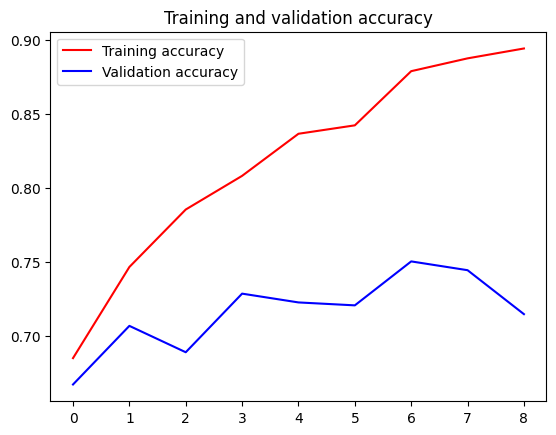

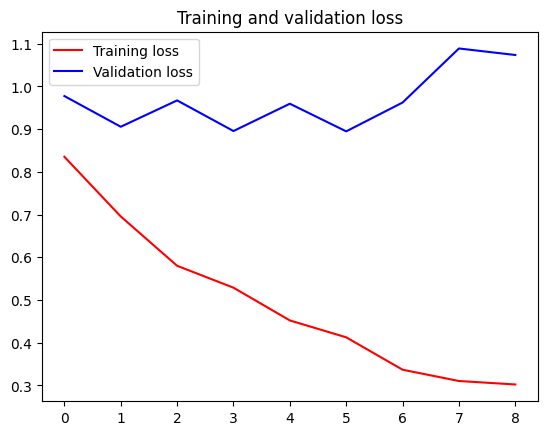

In [ ]:
create_plot(history, 'accuracy')
create_plot(history, 'loss')

Mengevaluasi model dengan dataset testing

In [ ]:
model.evaluate(test_dataset)

16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - accuracy: 0.7251 - loss: 0.7643


[0.7732717394828796, 0.7371541261672974]

Mendapatkan prediksi model dalam bentuk label kelas (y_pred). Membandingkan prediksi model (y_pred) dengan label sebenarnya (y_true) untuk mengevaluasi kinerja model, seperti menghitung akurasi, precision, recall, atau metrik lainnya.

In [ ]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([label.numpy() for _, label in test_dataset])

16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step


Membuat function untuk plotting confusion matrix

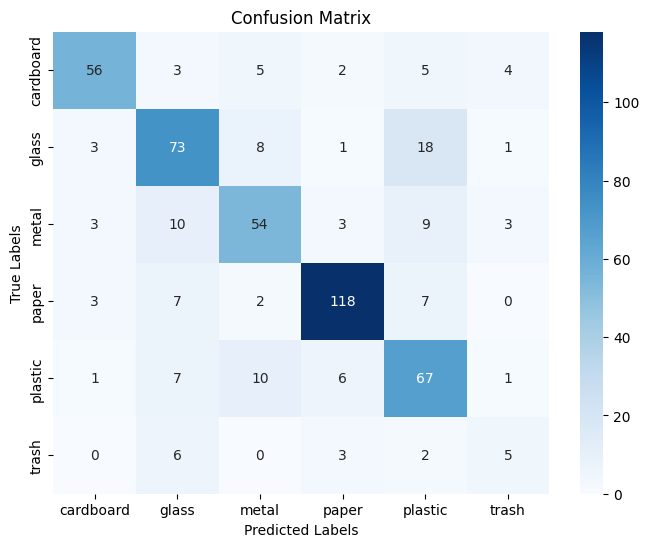

In [ ]:
def plot_confusion_matrix(label, y_true, y_pred):

  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label, yticklabels=label)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

plot_confusion_matrix(label_name, y_true, y_pred)

Menampilkan metrik akurasi, presisi, recall dan f1-score

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.75      0.79        75
           1       0.69      0.70      0.70       104
           2       0.68      0.66      0.67        82
           3       0.89      0.86      0.87       137
           4       0.62      0.73      0.67        92
           5       0.36      0.31      0.33        16

    accuracy                           0.74       506
   macro avg       0.68      0.67      0.67       506
weighted avg       0.74      0.74      0.74       506



Membuat fungsi untuk membuka image

In [ ]:
def open_image(img, size, raw_img=False):
  image = load_img(img, target_size=size)
  img = img_to_array(image)
  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  if raw_img:
    return img, image
  else:
    return img

Membuat function untuk memprediksi image yang dimasukkan ke model

In [ ]:
def predict_image(img, size, label):
  preprocess_img, image = open_image(img, size, raw_img=True)
  predictions = model.predict(preprocess_img)
  predicted_class_idx = np.argmax(predictions)
  predicted_class_label = label[predicted_class_idx]

  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Predicted Label: {predicted_class_label}')
  plt.show()

Saving Sample metal.jpg to Sample metal.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


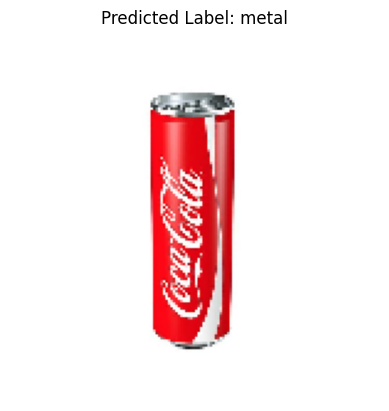

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  predict_image(fn, image_size, label_name)

Menyimpan model dalam format .h5

In [ ]:
model.save('model trashnet.h5')

Membuat file txt yang berisi mengenai library/package yang digunakan

In [ ]:
!pip freeze > requirements.txt

## Additional Insight

Model Bias :
1. Dikarenakan saya membuat arsitektur model buatan sendiri, model seringkali tidak akurat saat dilakukan testing pada data gambe yang saya download dari google
2. Model seringkali gagal untuk mengklasifikasikan botol gelas sebagai glass dan malah mengklasifikasikan botol gelas sebagai class lain
3. Transfer learning tidak saya lakukan dikarenakan keterbatasan memori saat akan meresize gambar, jika gambar diresize diatas 150x150, maka google colab akan mengalami session crashed

Dataset Issues :
1. Beberapa kelas sampah memiliki jumlah gambar yang lebih banyak dibandingkan kelas lainnya. Hal ini dapat menyebabkan bias pada model yang dilatih, di mana model cenderung lebih akurat dalam memprediksi kelas yang memiliki data lebih banyak.
2. Dataset mungkin kurang representatif terhadap variasi sampah di dunia nyata misalnya variasi bentuk, ukuran, warna, dan kondisi sampah.
3. Setelah cek dilaman dataset trashnet, dan cek pada gambar gambar yang ada, ada beberapa gambar diberi label yang salah, yang dapat membingungkan model terutama diclass trash, beberapa gambar yang seharusnya diidentifikasi sebagai class lain diidentifikasi sebagai class trash.
4. Dataset tidak memiliki gambar sampah dalam konteks yang bervariasi angle. Tidak adanya keragaman ini dapat menghasilkan model yang berkinerja baik pada dataset tetapi sulit untuk digeneralisasi ke gambar dunia nyata dengan kondisi yang berbeda beda.